In [39]:
!pip install feature-engine

### Initial Imports  

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import statsmodels.api as sm
from feature_engine.outliers import ArbitraryOutlierCapper, OutlierTrimmer


<br>
<br>
<br>

<hr>

### Quick Data Check  
- Peek at data structure & types  
- Missing values flagged  
- Duplicates counted  


In [41]:
df = pd.read_csv("/content/sample_data/calorie.csv")
print(df.info())
print(df.head())

print("\nMissing Values:\n", df.isnull().sum())
duplicated_rows = df[df.duplicated()]
print(f'There are {len(duplicated_rows)} duplicated rows in the DataFrame')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Age                            973 non-null    int64  
 1   Gender                         973 non-null    object 
 2   Weight (kg)                    973 non-null    float64
 3   Height (m)                     973 non-null    float64
 4   Max_BPM                        973 non-null    int64  
 5   Avg_BPM                        973 non-null    int64  
 6   Resting_BPM                    973 non-null    int64  
 7   Session_Duration (hours)       973 non-null    float64
 8   Calories_Burned                973 non-null    int64  
 9   Workout_Type                   973 non-null    object 
 10  Fat_Percentage                 973 non-null    float64
 11  Water_Intake (liters)          973 non-null    float64
 12  Workout_Frequency (days/week)  973 non-null    int

<br>
<br>
<br>

<hr>

### Categorical Feature Breakdown
- Key variables visualized:
  - Gender
  - Workout types
  - Experience levels
  - Workout frequency


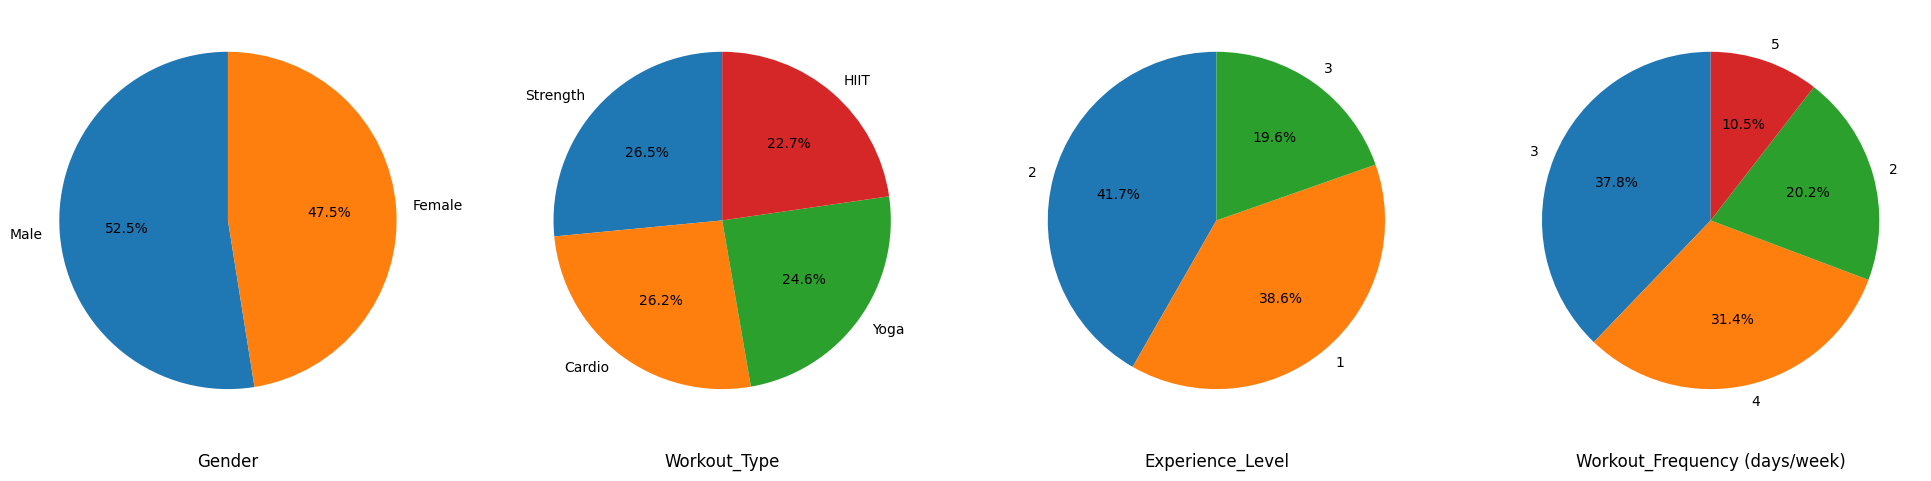

In [42]:
features = ['Gender', 'Workout_Type', 'Experience_Level', 'Workout_Frequency (days/week)']
plt.figure(figsize=(20, 6))
for i, col in enumerate(features):
    plt.subplot(1, 4, i + 1)
    x = df[col].value_counts()
    plt.pie(x.values, labels=x.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
    plt.title(col, y=-0.15, pad=20, fontsize=12)
plt.tight_layout(pad=3.0)
plt.show()

<br>
<br>
<br>

<hr>

### Label Encoding for Categorical Features
- Encodes text categories to numerical values
- Applied to: Gender, Workout_Type, Experience_Level


In [43]:
categorical_cols = ['Gender', 'Workout_Type', 'Experience_Level']
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


<br>
<br>
<br>

<hr>

### Outlier Handling Function
- **Methods Available**:
  - Capping (default): Replaces outliers with threshold values
  - Removal: Eliminates outlier rows entirely

- **Key Features**:
  - Automatic IQR-based threshold calculation
  - Custom capping thresholds supported
  - Visual verification option
  - Detailed reporting of changes


In [44]:
from feature_engine.outliers import ArbitraryOutlierCapper, OutlierTrimmer


def handle_outliers(df, columns, method='capping', visualize=False,
                    min_capping_dict=None, max_capping_dict=None, fold=1.5):
    original_shape = df.shape
    df = df.copy()

    for col in columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not in DataFrame.")
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise TypeError(f"Column '{col}' must be numeric.")

    if method == 'capping':
        if min_capping_dict is None or max_capping_dict is None:
            min_capping_dict = {}
            max_capping_dict = {}
            for col in columns:
                Q1 = df[col].quantile(0.25)
                Q3 = df[col].quantile(0.75)
                IQR = Q3 - Q1
                min_capping_dict[col] = Q1 - fold * IQR
                max_capping_dict[col] = Q3 + fold * IQR

        capper = ArbitraryOutlierCapper(
            max_capping_dict=max_capping_dict,
            min_capping_dict=min_capping_dict
        )
        df = capper.fit_transform(df)

    elif method == 'removal':
        trimmer = OutlierTrimmer(
            capping_method='iqr',
            tail='both',
            fold=fold,
            variables=columns
        )
        df = trimmer.fit_transform(df)

    else:
        raise ValueError("Method must be 'capping' or 'removal'.")

    if visualize:
        for col in columns:
            plt.figure(figsize=(8, 4))
            sns.boxplot(x=df[col])
            plt.title(f'Boxplot of {col} after {method}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    print("\n=== Outlier Handling Report ===")
    print(f"Original dataset shape: {original_shape}")
    print(f"New dataset shape: {df.shape}")
    if method == 'removal':
        print(f"Rows removed: {original_shape[0] - df.shape[0]}")
    print("\nDescriptive Statistics After Processing:")
    print(df[columns].describe())

    return df


<br>
<br>
<br>

<hr>

### Outlier Processing Execution
- **Action**: Removing outliers from all numerical features
- **Parameters**:
  - Strict IQR fold: 1.0 (aggressive outlier removal)
  - Method: Complete row removal
  - Visual diagnostics enabled


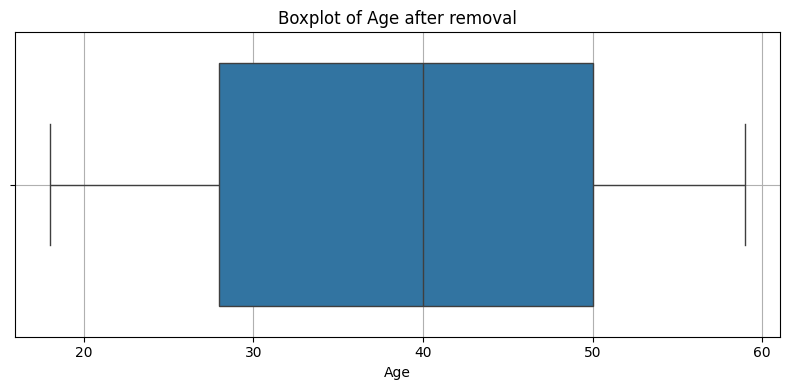

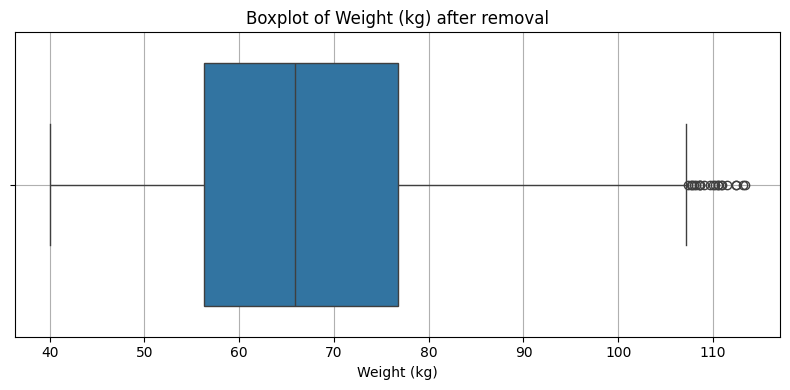

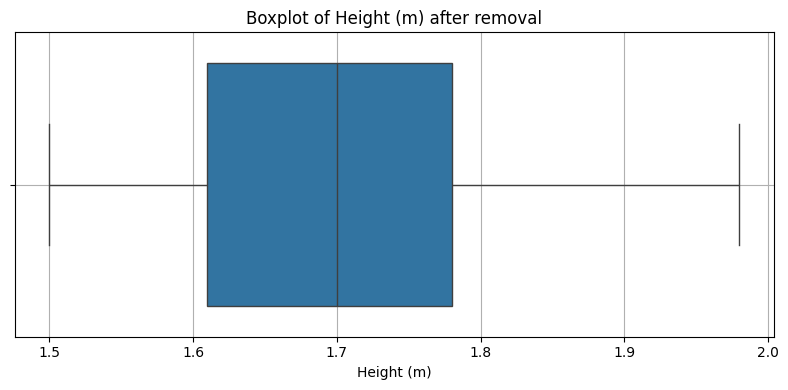

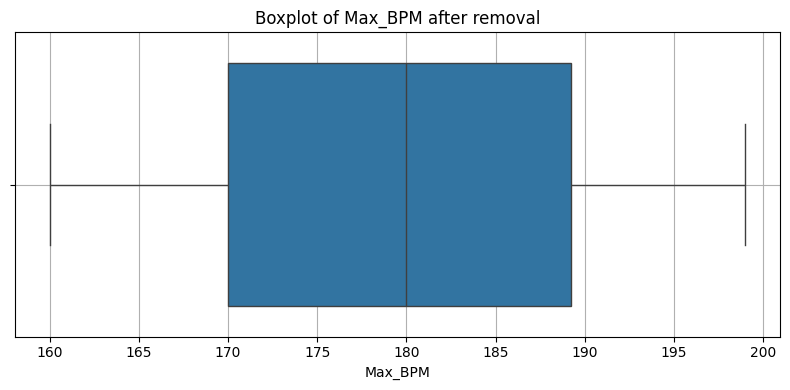

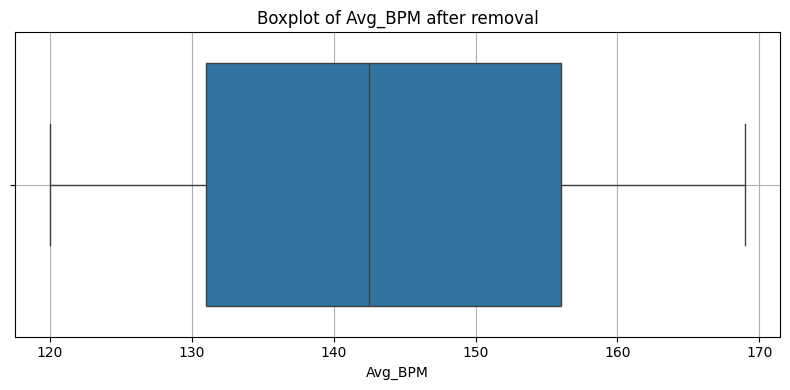

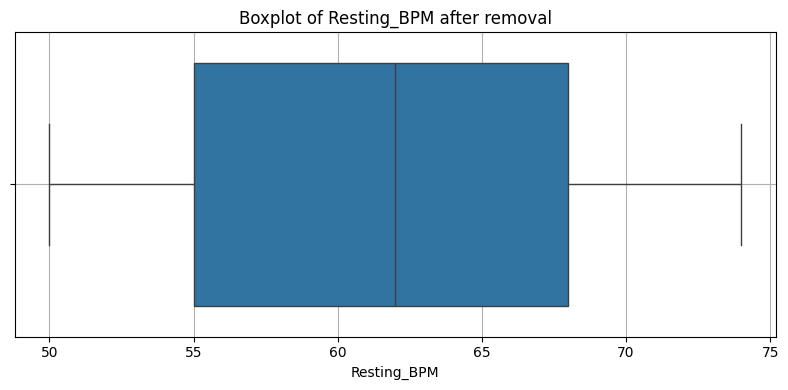

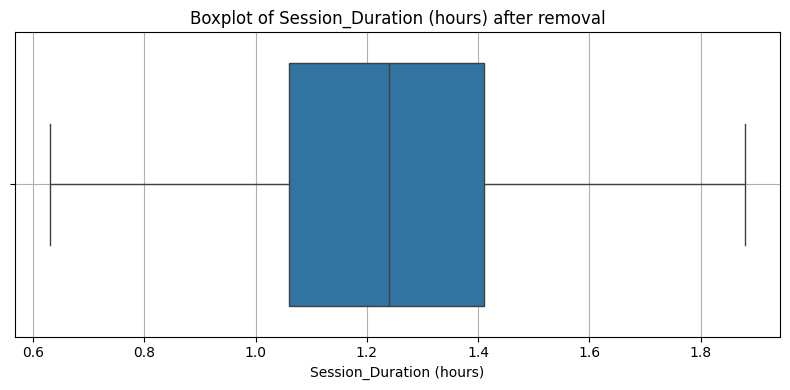

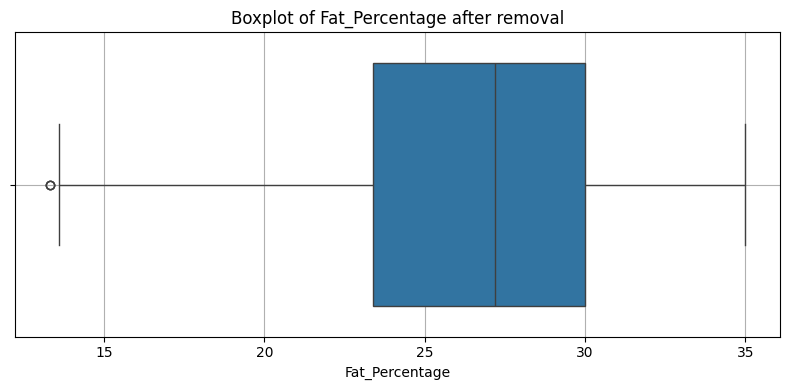

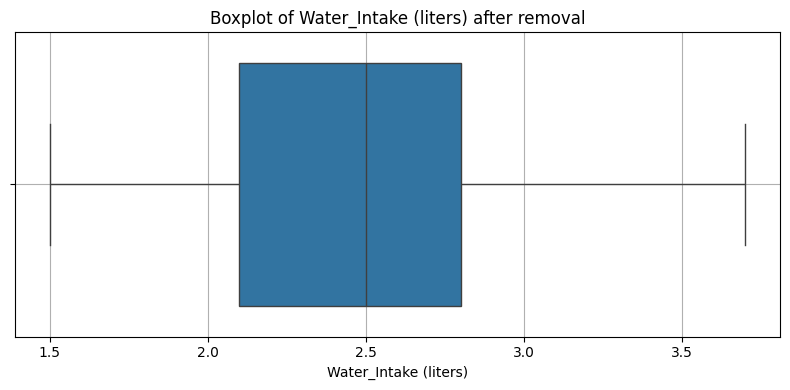

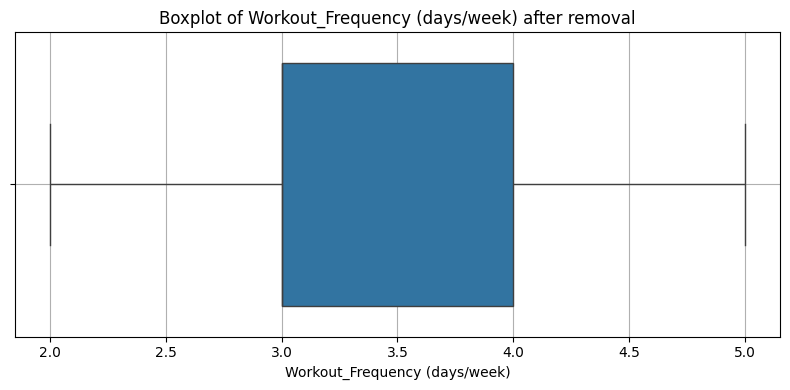

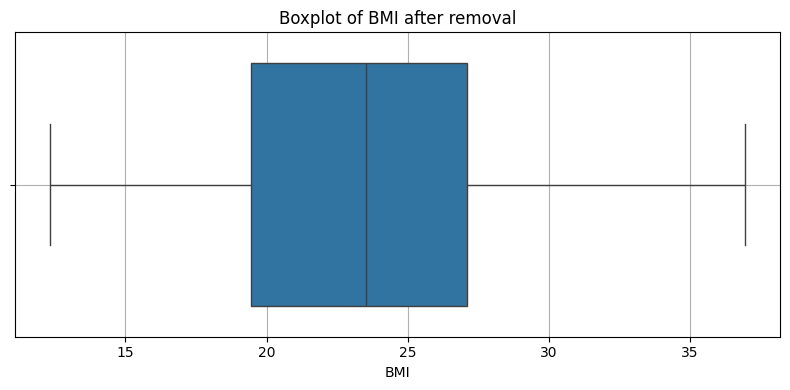


=== Outlier Handling Report ===
Original dataset shape: (973, 15)
New dataset shape: (740, 15)
Rows removed: 233

Descriptive Statistics After Processing:
              Age  Weight (kg)  Height (m)     Max_BPM     Avg_BPM  \
count  740.000000   740.000000  740.000000  740.000000  740.000000   
mean    38.894595    68.147297    1.706122  179.585135  143.325676   
std     12.075640    16.505667    0.119406   11.540341   14.242369   
min     18.000000    40.000000    1.500000  160.000000  120.000000   
25%     28.000000    56.300000    1.610000  170.000000  131.000000   
50%     40.000000    65.900000    1.700000  180.000000  142.500000   
75%     50.000000    76.725000    1.780000  189.250000  156.000000   
max     59.000000   113.400000    1.980000  199.000000  169.000000   

       Resting_BPM  Session_Duration (hours)  Fat_Percentage  \
count   740.000000                740.000000      740.000000   
mean     61.877027                  1.233932       26.499054   
std       7.393430   

In [45]:
numerical_cols = [
    'Age', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
    'Resting_BPM', 'Session_Duration (hours)', 'Fat_Percentage',
    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'BMI'
]
df = handle_outliers(df, columns=numerical_cols, method='removal', fold=1.0, visualize=True)


<br>
<br>
<br>

<hr>

### Feature Impact Visualization


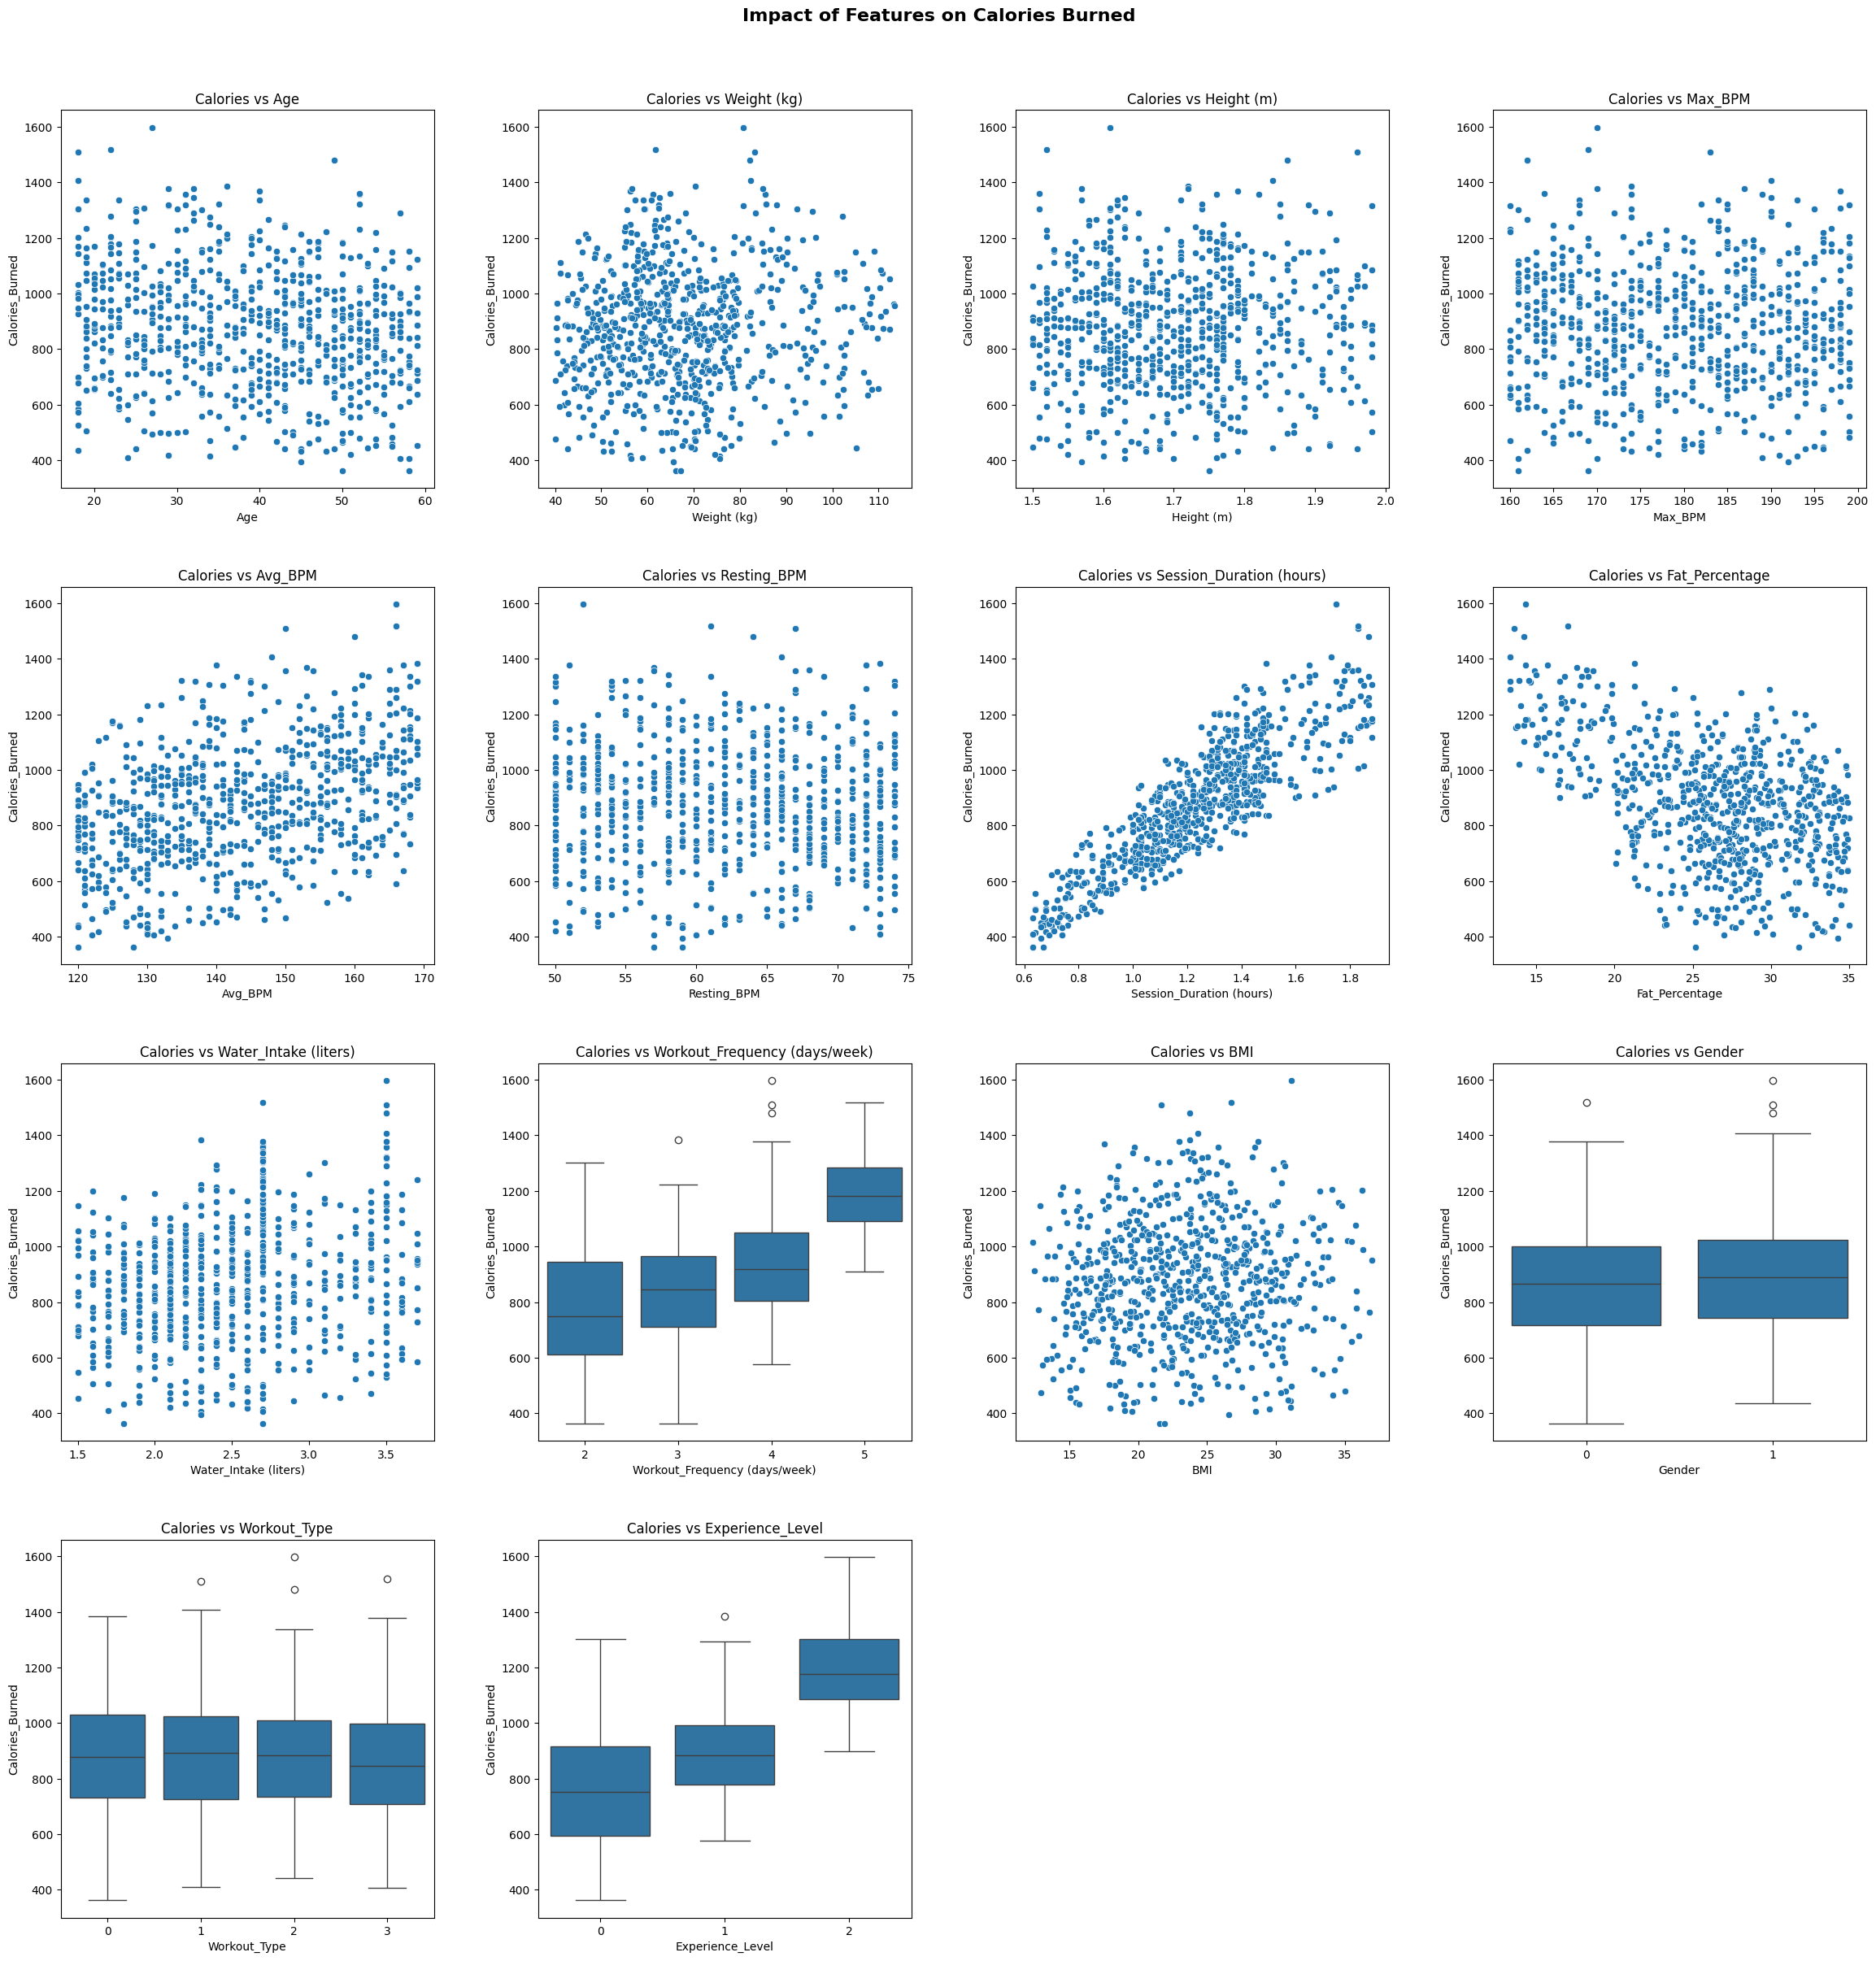

In [46]:
features_to_show = numerical_cols + categorical_cols
n_cols = 4
n_rows = int(np.ceil(len(features_to_show) / n_cols))
plt.figure(figsize=(24, 6 * n_rows))
for i, col in enumerate(features_to_show, 1):
    plt.subplot(n_rows, n_cols, i)
    if df[col].nunique() < 10:
        sns.boxplot(x=df[col], y=df['Calories_Burned'])
    else:
        sns.scatterplot(x=df[col], y=df['Calories_Burned'])
    plt.title(f'Calories vs {col}')
plt.tight_layout(pad=4.0)
plt.suptitle('Impact of Features on Calories Burned', y=1.02, fontsize=16, weight='bold')
plt.show()

<br>
<br>
<br>

<hr>

### Feature Scaling & Distribution Check


In [47]:
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

<Figure size 1500x1000 with 0 Axes>

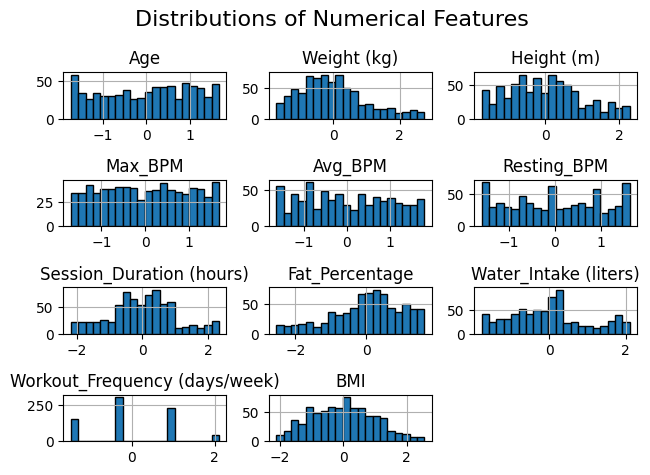

In [48]:
plt.figure(figsize=(15, 10))
df[numerical_cols].hist(bins=20, edgecolor='black')
plt.suptitle("Distributions of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

<br>
<br>
<br>

<hr>

### Correlation Analysis
- **Visualization**: Heatmap of feature correlations
- **Interpretation Guide**:
  - Values closer to ±1 indicate stronger relationships
  - Warm colors = positive correlation
  - Cool colors = negative correlation

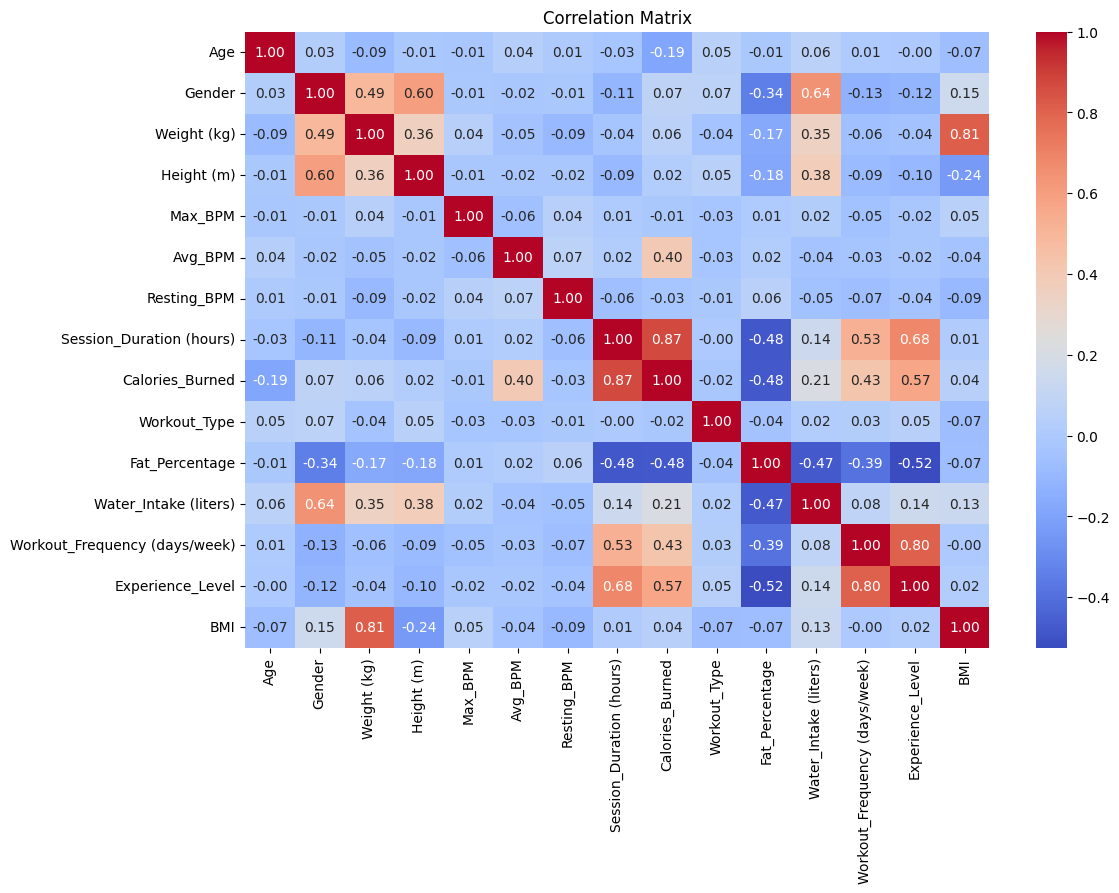

In [49]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

<br>
<br>
<br>

<hr>

### Multicollinearity Check Results
- **Threshold**: 0.9 correlation
- **Finding**: No feature pairs exceed threshold


In [50]:
corr_matrix = df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]

print("Highly correlated features to drop (threshold > 0.9):")
print(to_drop)


Highly correlated features to drop (threshold > 0.9):
[]


<br>
<br>
<br>

<hr>

### Feature Selection & Processing
- Selected features: Gender, Workout_Type, Experience_Level, Avg_BPM, Session_Duration, Fat_Percentage, Water_Intake, Workout_Frequency, BMI
- Applied MinMaxScaler to numerical features
- Split data: 70% train/val, 30% test
- Target variable: Calories_Burned

In [51]:
selected_features = [
    'Gender', 'Workout_Type', 'Experience_Level',
    'Avg_BPM', 'Session_Duration (hours)', 'Fat_Percentage',
    'Water_Intake (liters)', 'Workout_Frequency (days/week)', 'BMI'
]

X_optimized = df[selected_features].copy()
y = df['Calories_Burned']

from sklearn.preprocessing import MinMaxScaler

numeric_features = X_optimized.select_dtypes(include=[np.number]).columns
scaler = MinMaxScaler()
X_optimized[numeric_features] = scaler.fit_transform(X_optimized[numeric_features])

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_optimized, y, test_size=0.3, random_state=42)


<br>
<br>
<br>

<hr>

### Normalized Feature Distributions
- Numerical features after MinMax scaling (0-1 range)
- Histograms showing transformed distributions

<Figure size 1500x1000 with 0 Axes>

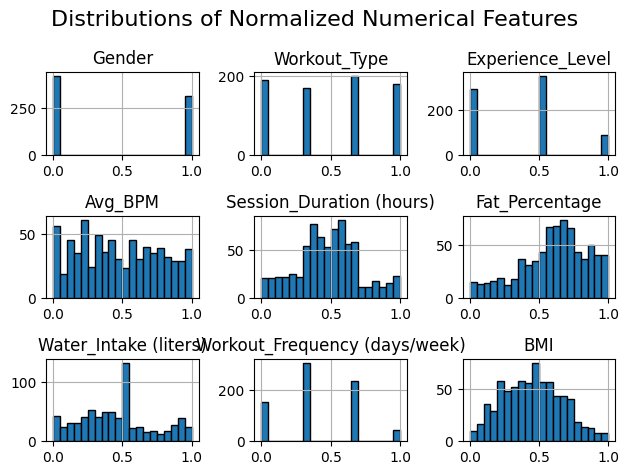

In [52]:
plot_columns = X_optimized.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 10))
X_optimized[plot_columns].hist(bins=20, edgecolor='black')
plt.suptitle("Distributions of Normalized Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()


<br>
<br>
<br>

<hr>

### Random Forest Model Evaluation
- Test set predictions generated
- Performance metrics:
  - Mean Absolute Error (MAE)
  - R-squared (R²)

In [53]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_val, y_train_val)
y_pred_rf_opt = rf.predict(X_test)
print("Optimized RF - MAE:", mean_absolute_error(y_test, y_pred_rf_opt))
print("Optimized RF - R²:", r2_score(y_test, y_pred_rf_opt))

Optimized RF - MAE: 46.47288288288288
Optimized RF - R²: 0.9414045524390512


### Polynomial Regression Evaluation  
- Polynomial features transformation  
- Linear regression model fitting  
- Test set performance metrics:  
  - MAE score  
  - R² score  

In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

poly = PolynomialFeatures(degree=2)
lin_reg = LinearRegression()

X_poly_train_val = poly.fit_transform(X_train_val)
X_poly_test = poly.transform(X_test)
lin_reg.fit(X_poly_train_val, y_train_val)
y_pred_poly_opt = lin_reg.predict(X_poly_test)
print("Optimized Poly - MAE:", mean_absolute_error(y_test, y_pred_poly_opt))
print("Optimized Poly - R²:", r2_score(y_test, y_pred_poly_opt))

Optimized Poly - MAE: 44.28804554136186
Optimized Poly - R²: 0.9529561931213982


In [55]:
X_train_val_2, X_test_2, y_train_val_2, y_test_2 = train_test_split(
    X_optimized, y, test_size=0.3, random_state=7)  # changed from 42 to 7

rf.fit(X_train_val_2, y_train_val_2)
y_pred_rf_2 = rf.predict(X_test_2)

print("\n[Random Forest - New Split]")
print("MAE:", mean_absolute_error(y_test_2, y_pred_rf_2))
print("R²:", r2_score(y_test_2, y_pred_rf_2))

X_poly_train_val_2 = poly.fit_transform(X_train_val_2)
X_poly_test_2 = poly.transform(X_test_2)

lin_reg.fit(X_poly_train_val_2, y_train_val_2)
y_pred_poly_2 = lin_reg.predict(X_poly_test_2)

print("\n[Polynomial Regression - New Split]")
print("MAE:", mean_absolute_error(y_test_2, y_pred_poly_2))
print("R²:", r2_score(y_test_2, y_pred_poly_2))



[Random Forest - New Split]
MAE: 50.755990990991
R²: 0.928540247902435

[Polynomial Regression - New Split]
MAE: 44.255251866511074
R²: 0.9538230048930201


In [56]:
X_train_val_3, X_test_3, y_train_val_3, y_test_3 = train_test_split(
    X_optimized, y, test_size=0.3, random_state=99)

rf.fit(X_train_val_3, y_train_val_3)
y_pred_rf_3 = rf.predict(X_test_3)

print("\n[Random Forest - Third Split]")
print("MAE:", mean_absolute_error(y_test_3, y_pred_rf_3))
print("R²:", r2_score(y_test_3, y_pred_rf_3))

X_poly_train_val_3 = poly.fit_transform(X_train_val_3)
X_poly_test_3 = poly.transform(X_test_3)

lin_reg.fit(X_poly_train_val_3, y_train_val_3)
y_pred_poly_3 = lin_reg.predict(X_poly_test_3)

print("\n[Polynomial Regression - Third Split]")
print("MAE:", mean_absolute_error(y_test_3, y_pred_poly_3))
print("R²:", r2_score(y_test_3, y_pred_poly_3))



[Random Forest - Third Split]
MAE: 49.472387387387386
R²: 0.9256213090323357

[Polynomial Regression - Third Split]
MAE: 44.36311236306972
R²: 0.9500629650296232


In [57]:
y_train_pred_rf = rf.predict(X_train_val)
print("\n[Random Forest - Train]")
print("MAE:", mean_absolute_error(y_train_val, y_train_pred_rf))
print("R²:", r2_score(y_train_val, y_train_pred_rf))

y_train_pred_poly = lin_reg.predict(X_poly_train_val)
print("\n[Polynomial Regression - Train]")
print("MAE:", mean_absolute_error(y_train_val, y_train_pred_poly))
print("R²:", r2_score(y_train_val, y_train_pred_poly))



[Random Forest - Train]
MAE: 27.34820463320463
R²: 0.9694872826375879

[Polynomial Regression - Train]
MAE: 42.40774686579196
R²: 0.953377423000331


<br>
<br>
<br>

<hr>

### Feature Importance Analysis  
- Random Forest feature rankings  
- Ordered by predictive importance  
- Visualized with horizontal bar plot  

/tmp/ipython-input-4076444787.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


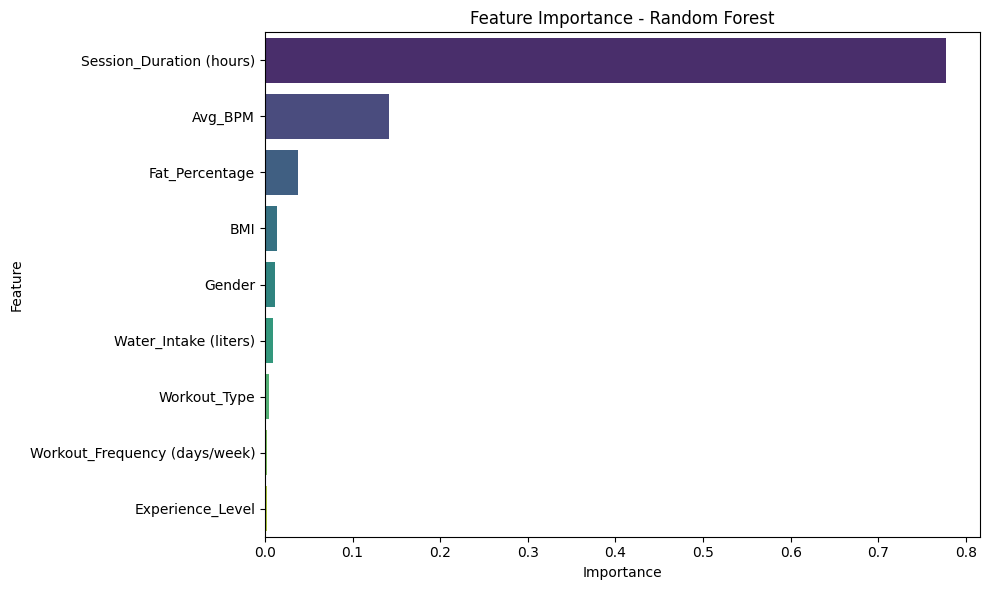

In [58]:
importance_df = pd.DataFrame({
    'Feature': X_optimized.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
plt.show()

### OLS Regression Results  
- Full statistical model summary  
- Includes coefficients, p-values, R²  
- Shows feature significance levels  

In [59]:
X_sm = sm.add_constant(X_optimized)
ols_model = sm.OLS(y, X_sm)
results = ols_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Calories_Burned   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     1391.
Date:                Sun, 10 Aug 2025   Prob (F-statistic):               0.00
Time:                        11:47:37   Log-Likelihood:                -3959.8
No. Observations:                 740   AIC:                             7940.
Df Residuals:                     730   BIC:                             7986.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### OLS Regression Analysis  
- **Model Fit**:  
  - R²: 0.945 (Excellent fit)  
  - Significant F-statistic (p=0.00)  

- **Key Predictors**:  
  - Avg_BPM (t=44.35, p=0.000)  
  - Session_Duration (t=72.43, p=0.000)  
  - Gender (t=15.73, p=0.000)  

- **Marginal Predictors**:  
  - BMI (p=0.038)  
  - Water_Intake (p=0.036)  
  - Workout_Type (p=0.029)  

- **Insignificant Predictors**:  
  - Experience_Level (p=0.844)  
  - Fat_Percentage (p=0.867)  
  - Workout_Frequency (p=0.648)  
  

<br>
<br>
<br>

<hr>

### Residual Analysis  
- Calculated studentized residuals  
- Combined with original features  
- Showing top 5 influential observations  

In [60]:
influence = results.get_influence()
resid_student = influence.resid_studentized_external

resid_df = pd.concat([X_optimized.reset_index(drop=True),
                      pd.Series(resid_student, name="Studentized Residuals")], axis=1)

print("\nTop 5 rows with Studentized Residuals:")
print(resid_df.head())



Top 5 rows with Studentized Residuals:
   Gender  Workout_Type  Experience_Level   Avg_BPM  Session_Duration (hours)  \
0     0.0      0.333333               0.5  0.632653                     0.536   
1     0.0      0.000000               0.5  0.040816                     0.384   
2     1.0      0.666667               0.0  0.775510                     0.008   
3     0.0      0.333333               1.0  0.734694                     0.768   
4     1.0      0.000000               0.5  1.000000                     0.688   

   Fat_Percentage  Water_Intake (liters)  Workout_Frequency (days/week)  \
0        0.949309               0.272727                       0.666667   
1        0.926267               0.363636                       0.666667   
2        0.732719               0.590909                       0.333333   
3        0.101382               0.545455                       1.000000   
4        0.368664               0.363636                       0.333333   

        BMI  Studentiz